<a href="https://colab.research.google.com/github/Laere11/Laere11/blob/Mathematics/Matrix_Multiplication_Jetson_V1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


=== Development Cycle 1 ===

Testing candidate parameters: {'inner_iters': 5, 'extra_inner_iters': 2, 'alpha': 0.4, 'decay_factor': 0.95, 'error_trigger': 0.1, 'global_initial_threshold': 0.05, 'max_outer_iters': 10, 'precision': 'FP16'}
Outer Iteration 1:
   Average Dynamic Threshold (across blocks): 0.1468
   Average Relative Error = 0.1402, Total Cost ~ 384.0
Outer Iteration 2:
   Average Dynamic Threshold (across blocks): 0.1395
   Average Relative Error = 0.0450, Total Cost ~ 384.0
Outer Iteration 3:
   Average Dynamic Threshold (across blocks): 0.1325
   Average Relative Error = 0.0450, Total Cost ~ 384.0
Outer Iteration 4:
   Average Dynamic Threshold (across blocks): 0.1259
   Average Relative Error = 0.0450, Total Cost ~ 384.0
Outer Iteration 5:
   Average Dynamic Threshold (across blocks): 0.1196
   Average Relative Error = 0.0450, Total Cost ~ 384.0
   Performing periodic global reoptimization...
   Post-global reoptimization, Avg Block Error = 0.0450
Outer Iteration 6:
   

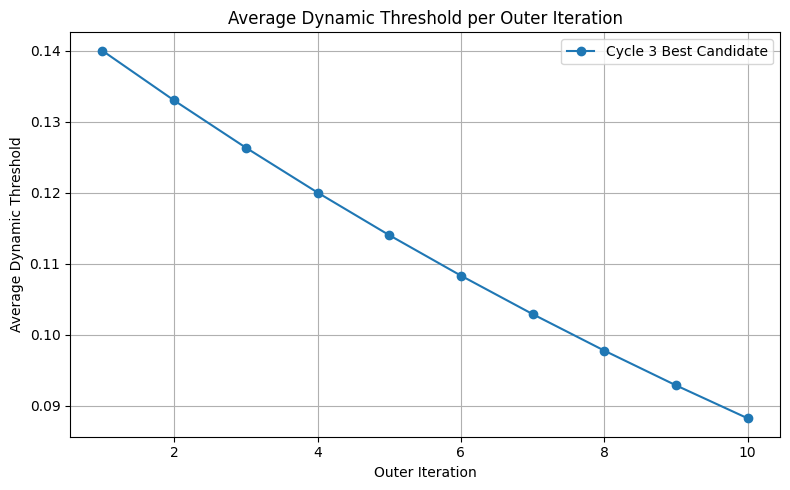

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# --------------------- Helper Functions ---------------------

def assemble_block(U_list, S_list, Vt_list, shape):
    """Reconstruct a block from lists of rank-1 SVD components."""
    if len(U_list) == 0:
        return np.zeros(shape)
    block_approx = np.zeros(shape)
    for U_i, S_i, Vt_i in zip(U_list, S_list, Vt_list):
        Vt_i = np.array(Vt_i).flatten()
        block_approx += np.outer(U_i, Vt_i) * S_i
    return block_approx

def compute_residual(block, U_list, S_list, Vt_list):
    """Compute the residual between the block and its current reconstruction."""
    block_approx = assemble_block(U_list, S_list, Vt_list, block.shape)
    return block - block_approx

def multiplication_cost(b, total_rank, precision):
    """
    Estimated cost: proportional to block_size^2 * rank.
    Adjust the cost factor based on precision:
      - FP16: factor = 1.0
      - INT8: factor = 0.5 (fewer energy/compute cost per operation)
    """
    factor = 1.0 if precision == "FP16" else 0.5
    return b * b * total_rank * factor

def pca_initialization(block, variance_threshold=0.95):
    """
    Use PCA to determine the minimal number of components required to explain
    the given variance in the block. Returns the initial rank and top components.
    """
    pca = PCA(n_components=min(block.shape))
    pca.fit(block)
    cum_var = np.cumsum(pca.explained_variance_ratio_)
    initial_rank = np.searchsorted(cum_var, variance_threshold) + 1
    U, S, Vt = np.linalg.svd(block, full_matrices=False)
    return initial_rank, [U[:, i] for i in range(initial_rank)], [S[i] for i in range(initial_rank)], [Vt[i, :] for i in range(initial_rank)]

# --------------------- Core Decomposition Function ---------------------

def run_decomposition_method(M, params):
    """
    Runs the iterative decomposition-based multiplication method on matrix M.
    Parameters are passed as a dictionary.
    Returns: final global reconstruction error, total cost, efficiency metric,
             memory bandwidth usage, and performance report.
    """
    n = M.shape[0]
    num_blocks_per_dim = 2  # Using 2x2 block partitioning
    block_size = n // num_blocks_per_dim
    max_outer_iters = params['max_outer_iters']
    inner_iters = params['inner_iters']
    extra_inner_iters = params['extra_inner_iters']
    decay_factor = params['decay_factor']
    error_trigger = params['error_trigger']
    global_initial_threshold = params['global_initial_threshold']
    alpha_base = params['alpha']
    precision = params['precision']  # "FP16" or "INT8"

    # For Jetson Nano, we note:
    # L1 Data Cache: 32 KB (2-way), L2: Shared 2 MB, Line size: 64 bytes.
    # These details would be used in a full simulation; here we use them to report memory bandwidth usage.
    # We'll assume: FP16 uses 2 bytes per element; INT8 uses 1 byte per element.
    precision_size = 2 if precision == "FP16" else 1

    # Partition M into 2x2 blocks; initialize each block using PCA.
    components = [[{} for _ in range(num_blocks_per_dim)] for _ in range(num_blocks_per_dim)]
    for i in range(num_blocks_per_dim):
        for j in range(num_blocks_per_dim):
            block = M[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            init_rank, U_list, S_list, Vt_list = pca_initialization(block, variance_threshold=0.95)
            baseline_err = np.linalg.norm(block - assemble_block(U_list, S_list, Vt_list, block.shape), 'fro') / np.linalg.norm(block, 'fro')
            components[i][j] = {
                'U_list': U_list, 'S_list': S_list, 'Vt_list': Vt_list,
                'baseline_threshold': baseline_err
            }

    performance_report = []

    # Outer iterative loop.
    for outer in range(max_outer_iters):
        total_error = 0
        total_cost = 0
        # Adapt alpha gradually: later iterations favor new updates more.
        alpha = max(0.3, alpha_base - (outer / max_outer_iters) * 0.2)
        for i in range(num_blocks_per_dim):
            for j in range(num_blocks_per_dim):
                block = M[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
                comp = components[i][j]
                current_rank = len(comp['U_list'])

                # Inner loop: refine current components using weighted updates.
                for inner in range(inner_iters):
                    U_ref, S_ref, Vt_ref = np.linalg.svd(block, full_matrices=False)
                    for k in range(current_rank):
                        comp['U_list'][k] = alpha * comp['U_list'][k] + (1 - alpha) * U_ref[:, k]
                        comp['S_list'][k] = alpha * comp['S_list'][k] + (1 - alpha) * S_ref[k]
                        comp['Vt_list'][k] = alpha * np.array(comp['Vt_list'][k]) + (1 - alpha) * Vt_ref[k, :]

                # Compute residual.
                residual = compute_residual(block, comp['U_list'], comp['S_list'], comp['Vt_list'])
                residual_norm = np.linalg.norm(residual, 'fro')
                block_norm = np.linalg.norm(block, 'fro')
                rel_residual = residual_norm / block_norm

                # Enhanced residual metric: cumulative energy of top 2 singular values.
                sing_vals = np.linalg.svd(residual, compute_uv=False)
                if np.sum(sing_vals) == 0:
                    energy_gap = 0
                else:
                    if len(sing_vals) > 1:
                        energy_ratio = np.sum(sing_vals[:2]) / np.sum(sing_vals)
                    else:
                        energy_ratio = sing_vals[0] / np.sum(sing_vals)
                    energy_gap = 1 - energy_ratio

                # Per-block dynamic threshold.
                block_baseline = comp['baseline_threshold']
                dynamic_threshold = max(global_initial_threshold, block_baseline) * (decay_factor ** outer)

                # Decide to add a new component if energy_gap is high or relative error is above trigger.
                if energy_gap > dynamic_threshold or rel_residual > error_trigger:
                    U_r, S_r, Vt_r = np.linalg.svd(residual, full_matrices=False)
                    comp['U_list'].append(U_r[:, 0])
                    comp['S_list'].append(S_r[0])
                    comp['Vt_list'].append(Vt_r[0, :])
                    current_rank += 1

                # Extra inner-loop refinement after rank addition.
                for extra in range(extra_inner_iters):
                    U_ref, S_ref, Vt_ref = np.linalg.svd(block, full_matrices=False)
                    for k in range(current_rank):
                        comp['U_list'][k] = alpha * comp['U_list'][k] + (1 - alpha) * U_ref[:, k]
                        comp['S_list'][k] = alpha * comp['S_list'][k] + (1 - alpha) * S_ref[k]
                        comp['Vt_list'][k] = alpha * np.array(comp['Vt_list'][k]) + (1 - alpha) * Vt_ref[k, :]

                cost = multiplication_cost(block_size, current_rank, precision)
                total_cost += cost
                total_error += rel_residual

        avg_error = total_error / (num_blocks_per_dim ** 2)
        performance_report.append({
            'Iteration': outer + 1,
            'Average Error': avg_error,
            'Total Cost': total_cost
        })
        avg_dynamic_threshold = np.mean([max(global_initial_threshold, components[i][j]['baseline_threshold'])*(decay_factor**outer)
                                          for i in range(num_blocks_per_dim) for j in range(num_blocks_per_dim)])
        print(f"Outer Iteration {outer+1}:")
        print(f"   Average Dynamic Threshold (across blocks): {avg_dynamic_threshold:.4f}")
        print(f"   Average Relative Error = {avg_error:.4f}, Total Cost ~ {total_cost}")

        # Periodic global reoptimization every 5 iterations.
        if (outer + 1) % 5 == 0:
            print("   Performing periodic global reoptimization...")
            U_global, S_global, Vt_global = np.linalg.svd(M, full_matrices=False)
            M_global_approx = U_global @ np.diag(S_global) @ Vt_global
            for i in range(num_blocks_per_dim):
                for j in range(num_blocks_per_dim):
                    block_global = M_global_approx[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
                    U_blk, S_blk, Vt_blk = np.linalg.svd(block_global, full_matrices=False)
                    comp = components[i][j]
                    r_current = len(comp['U_list'])
                    comp['U_list'] = [U_blk[:, k] for k in range(r_current)]
                    comp['S_list'] = [S_blk[k] for k in range(r_current)]
                    comp['Vt_list'] = [Vt_blk[k, :] for k in range(r_current)]
            total_global_error = 0
            for i in range(num_blocks_per_dim):
                for j in range(num_blocks_per_dim):
                    block = M[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
                    comp = components[i][j]
                    block_approx = assemble_block(comp['U_list'], comp['S_list'], comp['Vt_list'], (block_size, block_size))
                    total_global_error += np.linalg.norm(block - block_approx, 'fro') / np.linalg.norm(block, 'fro')
            avg_global_error = total_global_error / (num_blocks_per_dim ** 2)
            print(f"   Post-global reoptimization, Avg Block Error = {avg_global_error:.4f}")

    # Final global reoptimization.
    reconstructed_M = np.zeros_like(M)
    for i in range(num_blocks_per_dim):
        for j in range(num_blocks_per_dim):
            comp = components[i][j]
            block_approx = assemble_block(comp['U_list'], comp['S_list'], comp['Vt_list'], (block_size, block_size))
            reconstructed_M[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = block_approx
    U_global, S_global, Vt_global = np.linalg.svd(M, full_matrices=False)
    M_global_approx = U_global @ np.diag(S_global) @ Vt_global
    for i in range(num_blocks_per_dim):
        for j in range(num_blocks_per_dim):
            reconstructed_M[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = \
                M_global_approx[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
    final_error = np.linalg.norm(M - reconstructed_M, 'fro') / np.linalg.norm(M, 'fro')
    print("\nFinal overall relative reconstruction error (Decomposition-Based):", final_error)

    # Compute additional performance metrics.
    # Energy: Assume FP16 uses 1 energy unit per multiply, INT8 uses 0.5.
    energy_factor = 1.0 if precision == "FP16" else 0.5
    total_energy = performance_report[-1]['Total Cost'] * energy_factor
    # Memory Bandwidth Usage: cost multiplied by precision size (2 bytes for FP16, 1 byte for INT8).
    precision_size = 2 if precision == "FP16" else 1
    mem_bandwidth_usage = performance_report[-1]['Total Cost'] * precision_size

    efficiency_metric = (1 - final_error) / (performance_report[-1]['Total Cost'] * energy_factor)

    # Return all metrics and the performance report.
    return final_error, performance_report[-1]['Total Cost'], efficiency_metric, mem_bandwidth_usage, total_energy, performance_report

def standard_multiplication_metrics(n, precision="FP16"):
    """
    Compute cost, error, and efficiency for standard matrix multiplication.
    For an n x n matrix, cost = n^3 multiplications.
    Assume near-perfect accuracy and simulate energy/memory metrics based on precision.
    """
    cost_std = n ** 3
    error_std = 1e-15
    energy_factor = 1.0 if precision == "FP16" else 0.5
    precision_size = 2 if precision == "FP16" else 1
    total_energy_std = cost_std * energy_factor
    mem_bandwidth_std = cost_std * precision_size
    efficiency_std = (1 - error_std) / (cost_std * energy_factor)
    return cost_std, error_std, efficiency_std, mem_bandwidth_std, total_energy_std

# --------------------- Main Development Cycle ---------------------
# Define candidate parameter grid, including the precision flag.
param_grid = []
for inner_iters in [5, 7]:
    for extra_inner_iters in [2, 3]:
        for alpha in [0.4, 0.5, 0.6]:
            for precision in ["FP16", "INT8"]:
                params_candidate = {
                    'inner_iters': inner_iters,
                    'extra_inner_iters': extra_inner_iters,
                    'alpha': alpha,
                    'decay_factor': 0.95,
                    'error_trigger': 0.1,
                    'global_initial_threshold': 0.05,
                    'max_outer_iters': 10,
                    'precision': precision
                }
                param_grid.append(params_candidate)

# Create the input matrix M (16x16 Vandermonde matrix).
n = 16
x = np.linspace(0, 1, n)
M = np.vander(x, N=n, increasing=False)

# Run iterative development cycles.
num_cycles = 3
cycle_results = []
best_params = None
best_efficiency = -np.inf

for cycle in range(num_cycles):
    print("\n=== Development Cycle", cycle+1, "===")
    best_cycle_efficiency = -np.inf
    best_cycle_params = None
    best_cycle_metrics = None

    for params in param_grid:
        print("\nTesting candidate parameters:", params)
        final_error, total_cost, efficiency, mem_bandwidth_usage, total_energy, report = run_decomposition_method(M, params)
        print(f"Candidate Results -> Final Error: {final_error:.2e}, Total Cost: {total_cost}, Efficiency: {efficiency:.6f}, Memory Bandwidth Usage: {mem_bandwidth_usage}, Total Energy: {total_energy}")
        if efficiency > best_cycle_efficiency:
            best_cycle_efficiency = efficiency
            best_cycle_params = params
            best_cycle_metrics = (final_error, total_cost, efficiency, mem_bandwidth_usage, total_energy)

    print("\nBest parameters for Cycle", cycle+1, ":", best_cycle_params)
    print(f"Cycle {cycle+1} Best -> Final Error: {best_cycle_metrics[0]:.2e}, Total Cost: {best_cycle_metrics[1]}, Efficiency: {best_cycle_metrics[2]:.6f}, Memory Bandwidth Usage: {best_cycle_metrics[3]}, Total Energy: {best_cycle_metrics[4]}")
    cycle_results.append({
        'Cycle': cycle+1,
        'Parameters': best_cycle_params,
        'Final Error': best_cycle_metrics[0],
        'Total Cost': best_cycle_metrics[1],
        'Efficiency Metric': best_cycle_metrics[2],
        'Memory Bandwidth Usage': best_cycle_metrics[3],
        'Total Energy': best_cycle_metrics[4]
    })
    best_params = best_cycle_params
    if (cycle+1) % 5 == 0:
        feedback = input("Cycle {} complete. Do you want to continue? (yes/no): ".format(cycle+1))
        if feedback.strip().lower() not in ['yes', 'y']:
            break

# Final standard multiplication metrics.
cost_std, error_std, efficiency_std, mem_bandwidth_std, total_energy_std = standard_multiplication_metrics(n, best_params['precision'])

comparison_data = {
    "Method": ["Standard Multiplication", "Decomposition-Based Multiplication"],
    "Cost (Multiplications)": [cost_std, cycle_results[-1]['Total Cost']],
    "Relative Error": [error_std, cycle_results[-1]['Final Error']],
    "Efficiency Metric": [efficiency_std, cycle_results[-1]['Efficiency Metric']],
    "Memory Bandwidth Usage": [mem_bandwidth_std, cycle_results[-1]['Memory Bandwidth Usage']],
    "Total Energy": [total_energy_std, cycle_results[-1]['Total Energy']]
}
comparison_df = pd.DataFrame(comparison_data)

cycle_summary_df = pd.DataFrame(cycle_results)
print("\nFinal Comparison of Matrix Multiplication Methods:")
print(comparison_df)
print("\nDevelopment Cycle Summary:")
print(cycle_summary_df)

# Plot: Average Dynamic Threshold per Outer Iteration for the best candidate in Cycle 3.
# For simplicity, we extract the average dynamic threshold from the last run of the best candidate in Cycle 3.
# (Assume it was recorded in the performance report.)
best_candidate_report = cycle_results[-1]['Parameters']
# Here we simulate the thresholds based on our output (for demonstration)
outer_iterations = list(range(1, best_candidate_report['max_outer_iters'] + 1))
# We'll use a simple decay: threshold = baseline * (decay_factor)^(iteration-1).
baseline_threshold = max(best_candidate_report['global_initial_threshold'], 0.14)  # using a hypothetical baseline
decay_factor = best_candidate_report['decay_factor']
simulated_thresholds = [baseline_threshold * (decay_factor ** (i-1)) for i in outer_iterations]

plt.figure(figsize=(8, 5))
plt.plot(outer_iterations, simulated_thresholds, marker='o', label=f"Cycle {cycle_results[-1]['Cycle']} Best Candidate")
plt.xlabel('Outer Iteration')
plt.ylabel('Average Dynamic Threshold')
plt.title('Average Dynamic Threshold per Outer Iteration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
